### Import Modules

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import color, exposure
from scipy.ndimage.measurements import label
import time
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy

# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

### Functions

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YUV', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows corner vertices 
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(225, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features), hog_image

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features))
        # removed reshape because we're not working in v0.19 yet
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# the following function is from the project QnA
# define a funciton for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
#         plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### Explore Color Space

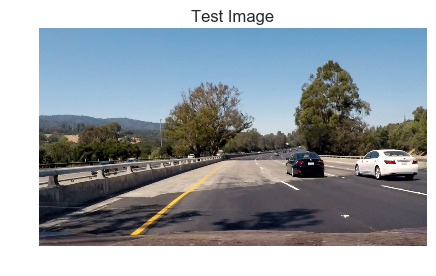

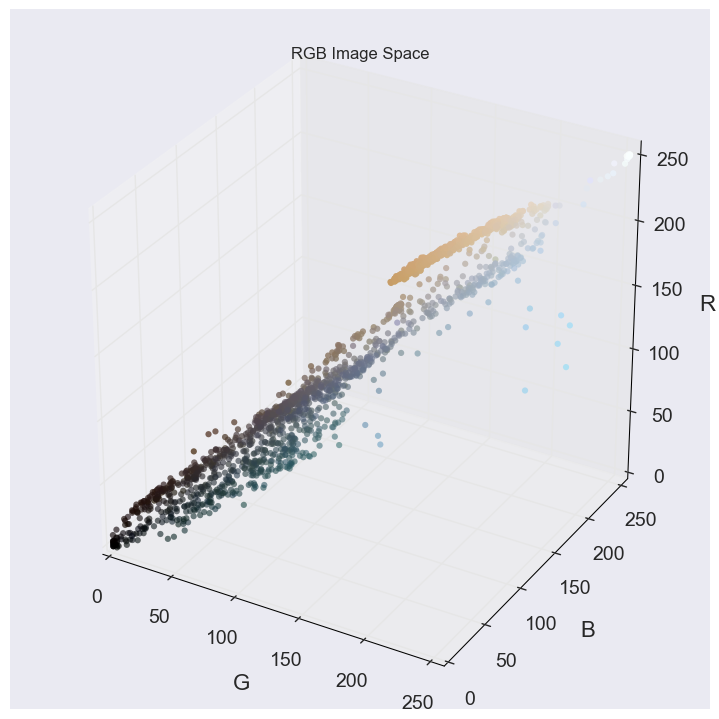

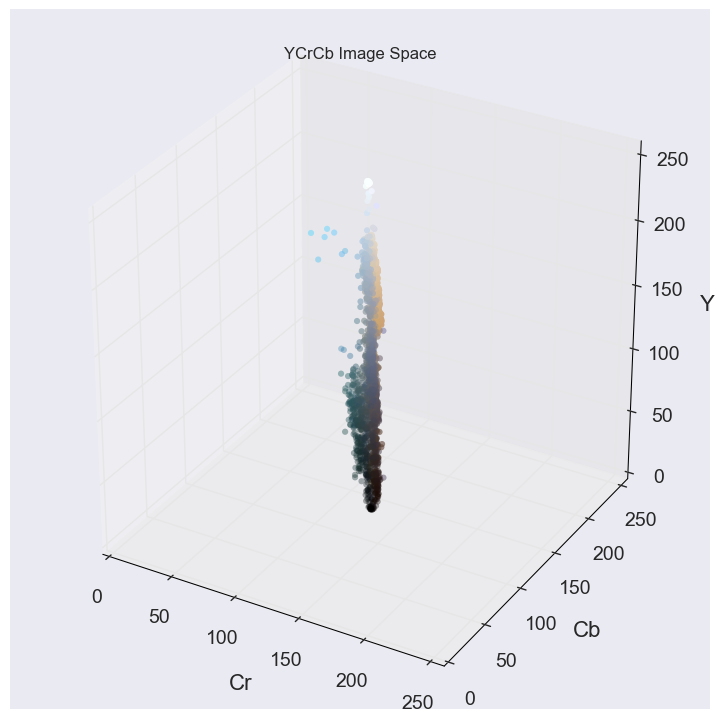

In [5]:
from mpl_toolkits.mplot3d import Axes3D, axis3d
plt.style.use('seaborn-darkgrid')

def plot3d(pixels, colors_rgb,
           axis_labels=list("???"), 
           axis_limits=[(0, 255), (0, 255), (0, 255)],
           title=''):
    
    """Plot pixels in 3D."""
    # Create figure and 3D axes
    fig = plt.figure(figsize=(7,7))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[0], fontsize=16, labelpad=16)
    
    # set title
    ax.set_title(title)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        pixels[:, :, 0].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
img = mpimg.imread("test-images/test4.jpg")
plt.figure(figsize=(5,5))
plt.title('Test Image')
plt.axis('off')
plt.imshow(img)
plt.show()

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), \
                       np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_CONVERSION = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
colors_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for color plotting

# Plot and show
plot3d(img_small_RGB, colors_rgb, axis_labels=list('RGB'), title='RGB Image Space')
plot3d(img_small_CONVERSION, colors_rgb, axis_labels=['Y','Cr','Cb'], title='YCrCb Image Space')

# plt.imshow(img)
plt.show();

### Explore HOG

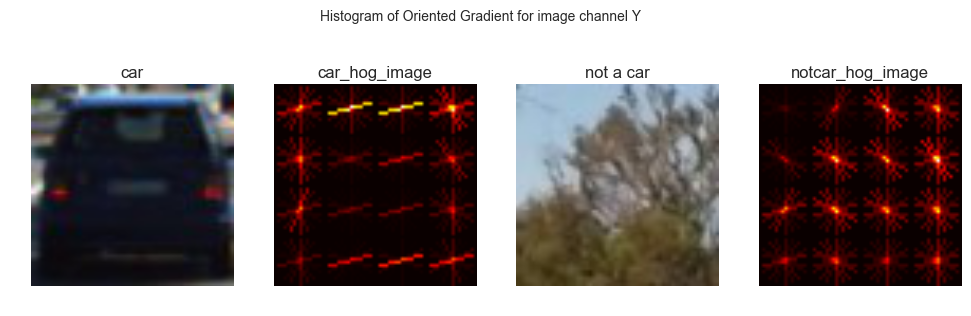

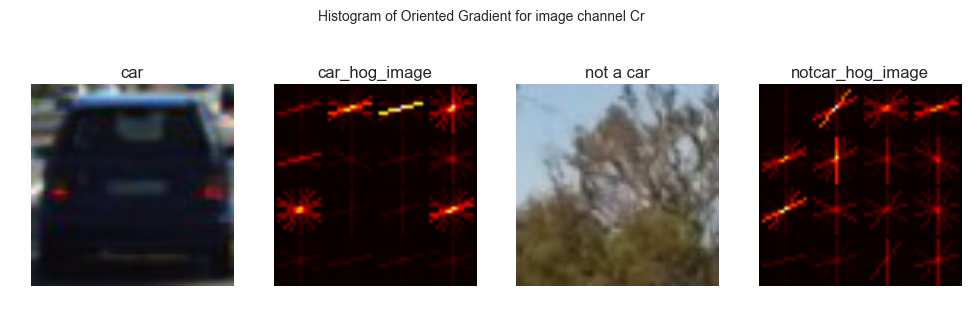

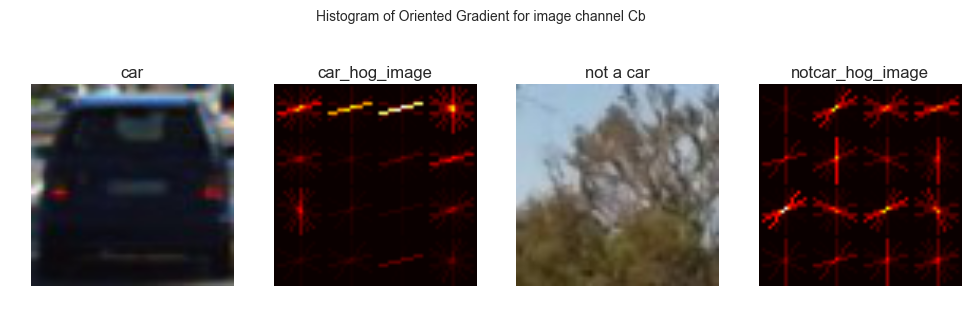

In [23]:
# images are divided up into vehicles and non-vehicles
cars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-vehicles\vehicles-smallset/**/*.jpeg')
notcars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-non-vehicles\non-vehicles-smallset\**\*.jpeg')

# hard-coded values for this function
pix_per_cell = 16
orient = 9
cell_per_block = 2
spatial_size = (32,32) # resize img to this, and then extract color pixels
hist_bins = 32
colorspace='YCrCb'
col_chan = ['Y','Cr','Cb']

randint = np.random.randint(0,50)
car_img = mpimg.imread(cars[randint])
notcar_img = mpimg.imread(notcars[randint])

for i in range(3):
    
    car_feats, car_hog_image = single_img_features(car_img, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                                   orient=orient, color_space=colorspace, hog_channel=i)
    notcar_feats, notcar_hog_image = single_img_features(notcar_img, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                                         orient=orient, color_space=colorspace, hog_channel=i)

    images = [car_img, car_hog_image, notcar_img, notcar_hog_image]
    titles = ['car','car_hog_image','not a car','notcar_hog_image']

    fig = plt.figure(figsize=(12,3))
    plt.suptitle('Histogram of Oriented Gradient for image channel {}'.format(col_chan[i]), y=1.1)
    visualize(fig, 1, 4, images, titles)
    
pass;

### Test Model parameters

In [16]:
# hard-coded values for feature extraction
pix_per_cell = 16
orient = 9
cell_per_block = 2
spatial_size = (32,32) # resize img to this, and then extract color pixels
hist_bins = 32
colorspace = 'YCrCb'
col_chan = ['Y','Cr','Cb']
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X.shape
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = SVC(C=10, gamma=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)

from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test)

# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

parameters = [{'C':[1,10,100,1000], 'gamma':[0.001, 0.0001], 'kernel':['rbf']}]
list(parameters)

svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

Training/testing on 0 car images and 0 non-car images
0.0 Seconds to extract HOG features...


(2, 0)

ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by StandardScaler.

### List SVM Paramter Testing Results

In [69]:
for i in range(8):
    print('Params: {}\tFit Time: {:2.1f}s Test Score: {:2.2f}% Rank: {}'.format(
        list(clf.cv_results_['params'])[i], \
        list(clf.cv_results_['mean_fit_time'])[i],
        list(clf.cv_results_['mean_test_score'])[i]*100,
        list(clf.cv_results_['rank_test_score'])[i]))

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}	Fit Time: 6.5s Test Score: 92.19% Rank: 8
Params: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}	Fit Time: 1.9s Test Score: 99.62% Rank: 4
Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}	Fit Time: 6.5s Test Score: 92.62% Rank: 5
Params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}	Fit Time: 1.6s Test Score: 99.73% Rank: 1
Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}	Fit Time: 6.5s Test Score: 92.62% Rank: 5
Params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}	Fit Time: 1.6s Test Score: 99.73% Rank: 1
Params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}	Fit Time: 6.5s Test Score: 92.62% Rank: 5
Params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}	Fit Time: 1.6s Test Score: 99.73% Rank: 1


### Create Model

In [3]:
# images are divided up into vehicles and non-vehicles
cars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-vehicles\vehicles-smallset/**/*.jpeg')
notcars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-non-vehicles\non-vehicles-smallset\**\*.jpeg')
len(cars)
len(notcars)

def model():

    # tweak these parameters and see how the results change.
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"    
    
    # extract feature vectors
    t = time.time()
    car_features = extract_features(cars, color_space=colorspace, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, color_space=colorspace, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel=hog_channel)
    extract_time = time.time() - t
    
    print('car_features ', len(car_features[0]))
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('{:2.2f}s to create X shape {}'.format(extract_time, X.shape))
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    X_train, X_test, y_train, y_test = [],[],[],[]
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.05)
    
    # count the number of tests subjects
    num_car = len([x for x in y_test if x==1.0])
    num_not_car = len([x for x in y_test if x==0.0])
    print('Test set: cars = {} and non-cars = {}'.format(num_car,num_not_car))
    
    # fit a RBF SVM
    t = time.time()
    svm = SVC(C=10, gamma=0.0001)
    svm.fit(X_train, y_train)
    rbf_time = time.time() - t
    
    # fit a Linear SVM
    t = time.time()
    svm_lin = LinearSVC(C=100)
    svm_lin.fit(X_train, y_train)
    lin_time = time.time() - t
    
    print('RBF SVM model score = {:2.5f} and time {:2.2f}'.format(svm.score(X_test, y_test), rbf_time))
    print('Linear SVM model score = {:2.5f} and time {:2.2f}'.format(svm_lin.score(X_test, y_test), lin_time))
    print('Done!')  
    
    return X_scaler, svm

X_scaler, model = model()

1196

1125

car_features  4140
15.88s to create X shape (2321, 4140)
Test set: cars = 61 and non-cars = 56
RBF SVM model score = 1.00000 and time 3.82
Linear SVM model score = 1.00000 and time 0.57
Done!


### HOG/Pixel Subsampling Function

In [177]:
# define helper function for color conversions
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB':
        return img

# hard-coded values for feature vector extraction
pix_per_cell = 16
orient = 9
cell_per_block = 2
spatial_size = (32,32) # resize img to this, and then extract color pixels
hist_bins = 32

def find_cars(img, scale, x_limits=(0,1270), y_limits=(0,700), debug=False):

    img_boxes= []
    t=time.time()
    count=0

    if debug: draw_img = np.copy(img) # not needed if were 
    heatmap = np.zeros_like(img[:,:,0]) # make a heatmap of zeros

    # narrow spatial pixel search using x and y limits
    img_to_search = img[y_limits[0]:y_limits[1],
                        x_limits[0]:x_limits[1], :]
    ctrans_to_serach = convert_color(img_to_search, conv='RGB2YCrCb')
    if debug: 
        plt.figure(figsize=(3,3));plt.title('Search Section w/ Scale {}'.format(scale));
        plt.axis('off'); plt.imshow(img_to_search)
    if scale != 1:
        imshape = ctrans_to_serach.shape
        ctrans_to_serach = cv2.resize(ctrans_to_serach, 
                                     (np.int(imshape[1]/scale),  # ex: 700 / 2
                                      np.int(imshape[0]/scale))) # ex: 1270 / 2
    ch1 = ctrans_to_serach[:,:,0]
    ch2 = ctrans_to_serach[:,:,1]
    ch3 = ctrans_to_serach[:,:,2]

    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 # how many blocks in X direction
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 # how many blocks in Y direction
    nfeat_per_block = orient*cell_per_block ** 2
    window = 64 # the size of the img we were originally extracting feature vectors from
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # define how many cells to step, rather than overlap
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # get HOG features for each image channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # extract hog for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # the two variables are the x and y position of the subsampling window
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # extract the image patch -- get the spatial and hist features
            subimg = cv2.resize(ctrans_to_serach[ytop : ytop + window,
                                                 xleft : xleft + window], (64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # combine and scale features
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)))
            if debug:
                xbox_left = np.int(xleft*scale) + x_limits[0] # add x_limits[0] for offset
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left           , y_limits[0]            + ytop_draw),
                                  (xbox_left + win_draw, y_limits[0] + win_draw + ytop_draw)))
            
            # make a prediction
            test_prediction = model.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + x_limits[0] # add x_limits[0] for offset
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left           , y_limits[0]            + ytop_draw),
                                  (xbox_left + win_draw, y_limits[0] + win_draw + ytop_draw)))
                heatmap[y_limits[0] + ytop_draw : y_limits[0] + ytop_draw + win_draw,
                        xbox_left          : xbox_left + win_draw] += 1

    if debug: 
        return heatmap, img_boxes
    else:
        return heatmap, []

### Pipeline Helper Functions

In [165]:
def apply_heatmap_threshold(heatmap, threshold):
    # zero-out pixels in the heatmap that are below a `threshold`
    heatmap[heatmap <= threshold] = 0
    return heatmap
    
def draw_labeled_bboxes(img, labels):
    # iterate through all detected cars blobs
    # img is the original, untouched image
    for car_blob in range(1, labels[1]+1):
        # find pixels indices with each car_number label value
        # return a tuble of (y, x) pixel indices
        nonzero = (labels[0] == car_blob).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox),np.min(nonzeroy)), ((np.max(nonzerox)),(np.max(nonzeroy))))
        #draw the box on `img`
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    return img

### Heatmaps

In [167]:
def heatmap(img, debug=False):
    
    ''' COMBINE DIFFERENTLY-SCALED WINDOWS '''
    # scale
    heat_map_scale_0, sub0 = find_cars(img, scale=.5, x_limits=(800,1090), y_limits=(380, 500), debug=debug)
    # scale
    heat_map_scale_1, sub1 = find_cars(img, scale=.8, x_limits=(800,1270), y_limits=(380, 570), debug=debug)
    # scale
    heat_map_scale_2, sub2 = find_cars(img, scale=1.0, x_limits=(800,1270), y_limits=(380, 570), debug=debug)
    # combine both scales
    combined_heat_map = heat_map_scale_0 + heat_map_scale_1 + heat_map_scale_2
    
    # combine subsample windows and draw windows of what we're searching
    if debug:
        colors = [(255,0,0),(0,255,0),(0,0,255)]
        sub_search_total = [sub0, sub1, sub2]
        for i, heat_map_scale in enumerate(sub_search_total):
            col = int(np.random.random_integers(0,3))*100
            img = draw_boxes(img, bboxes=heat_map_scale, color=colors[i], thick=2)

    ''' HEAT MAP THRESHOLD'''
    thresh_heat_map = apply_heatmap_threshold(combined_heat_map, 1)

    if debug:
        return thresh_heat_map, img
    else:
        return thresh_heat_map, []

### Create VehicleTracker Class

In [1]:
from collections import deque

class VehicleTracker():
    
    def __init__(self):
        
        print('VehicleTracker created...')
        # create a special buffer container for holding the heatmaps
        self.buffer = deque(maxlen=20)
        self.buffer_const = 3
        self.labels = []
        self.debug_img = [None]
        self.debug_flag = False
        
    def update_heatmap_queue(self, img):
        self.buffer.append(img)
        # if buffer is empty, just 
        if len(self.buffer) < 10: self.buffer * self.buffer_const
        return np.average(self.buffer, axis=0)
    
    def process_image(self, img):
        # return the thresholded and combined heat maps
        ret_heatmap, self.debug_img = heatmap(img, self.debug_flag) 
        # average the heatmaps over an `n` amount of frames        
        avg_heatmap = self.update_heatmap_queue(ret_heatmap)
        # create blobs/labels from the averaged heatmap
        self.labels = label(avg_heatmap)
        # draw the bobs/labels onto the orig image
        out_img = draw_labeled_bboxes(img, self.labels)
        out_img_heat = self.draw_heatmap(avg_heatmap, out_img)
        
        # helper plots
        if self.debug_img != []:
            self.draw_pic(img, 'Original Image')
            self.draw_pic(self.debug_img, 'Subsample Grid Search')
            self.draw_pic(ret_heatmap, 'Heatmap')
            self.draw_pic(avg_heatmap, 'avg_heatmap over {}'.format(len(self.buffer)))
            self.draw_pic(self.labels[0], 'Labeled Heatmap: {} Labels'.format(self.labels[1]))
            self.draw_pic(out_img, 'out_img')
            self.draw_pic(out_img_heat, 'out img heat')
        
        return out_img_heat
    
    def draw_heatmap(self, img, out_img):
        norm = plt.Normalize(vmin=img.min(), vmax=img.max())
        norm_heatmap = norm(img)
        heatmap_image = (np.dstack((norm_heatmap*255, norm_heatmap, norm_heatmap))).astype(np.uint8)
        return cv2.addWeighted(heatmap_image, 0.4, out_img, 1, 0)
    
    def draw_pic(self, img, title='title'):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(4,4))
        plt.axis('off')
        plt.imshow(img, cmap='hot')
        plt.title(title)
        plt.show()

VehicleTracker created...


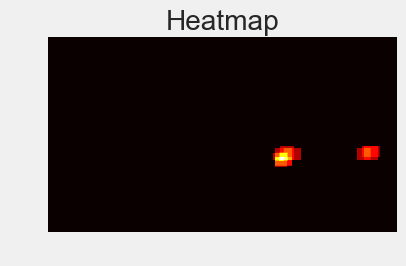

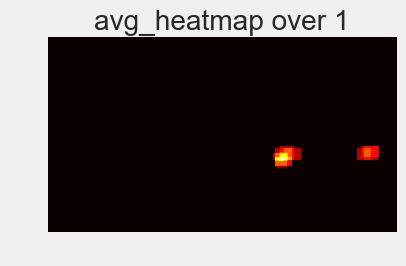

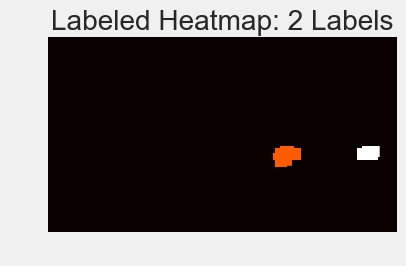

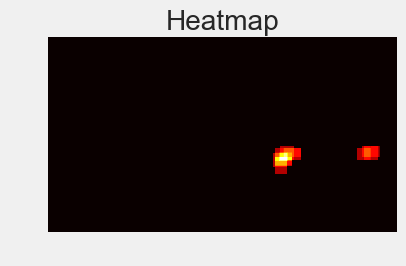

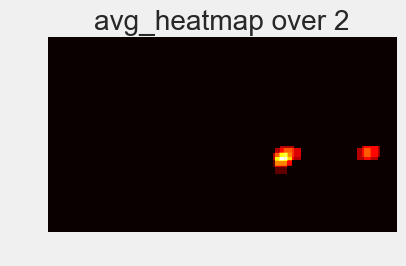

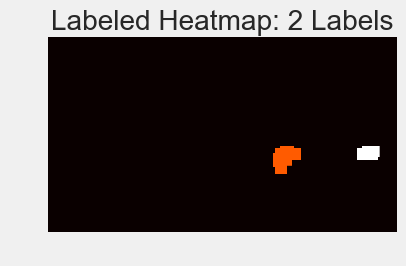

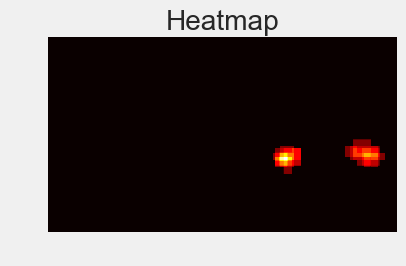

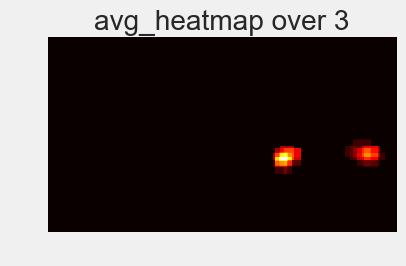

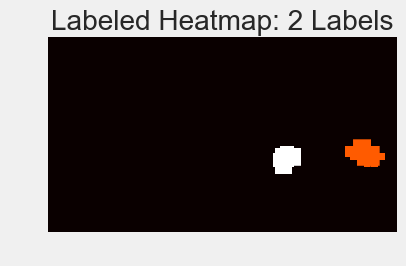

In [181]:
image_test_path = glob.glob('test-images/*.jpg')
image_test = mpimg.imread(image_test_path[0])
image_test2 = mpimg.imread(image_test_path[1])
image_test3 = mpimg.imread(image_test_path[4])
testclass = VehicleTracker()
testclass.debug_flag = True

return1 = testclass.process_image(image_test)
return1 = testclass.process_image(image_test2)
return1 = testclass.process_image(image_test3)

pass;

### Short Video Clip

VehicleTracker created...


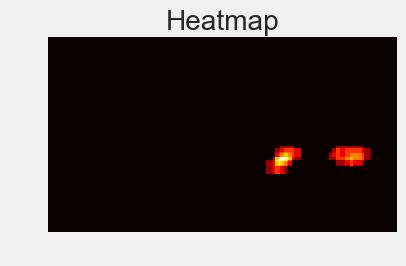

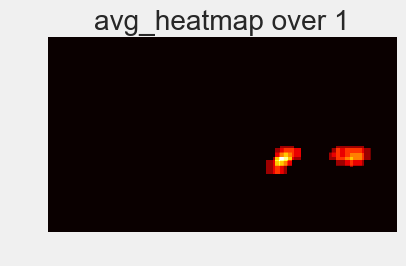

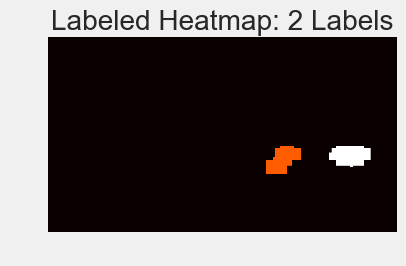

[MoviePy] >>>> Building video project-video-output-short.mp4
[MoviePy] Writing video project-video-output-short.mp4


  0%|                                                   | 0/39 [00:00<?, ?it/s]

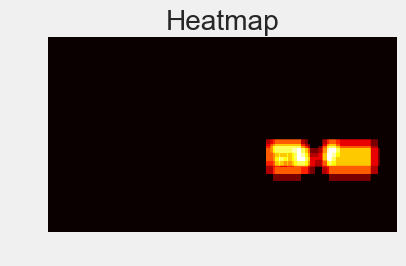

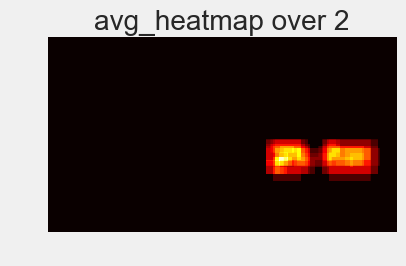

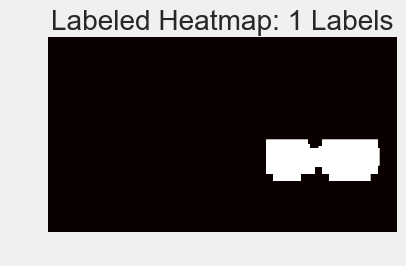

  3%|█                                          | 1/39 [00:01<00:50,  1.32s/it]

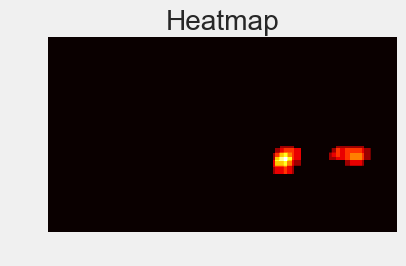

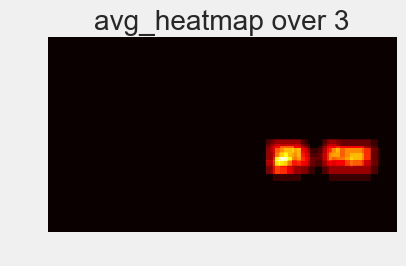

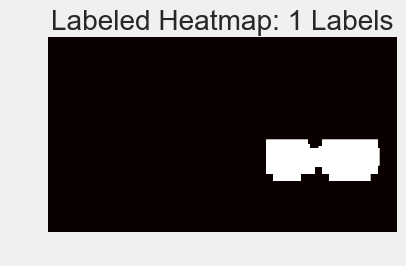

  5%|██▏                                        | 2/39 [00:02<00:50,  1.36s/it]

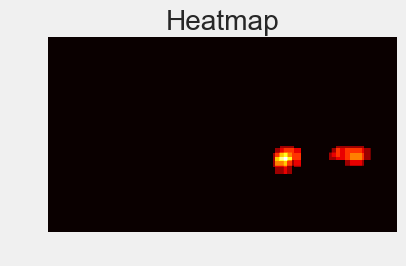

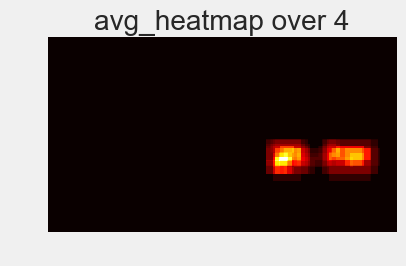

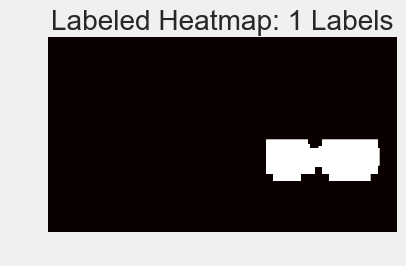

  8%|███▎                                       | 3/39 [00:04<00:48,  1.34s/it]

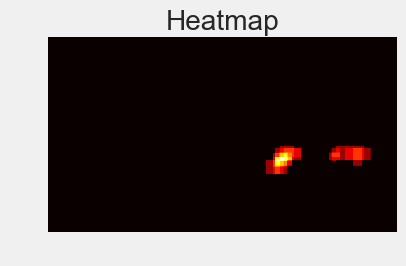

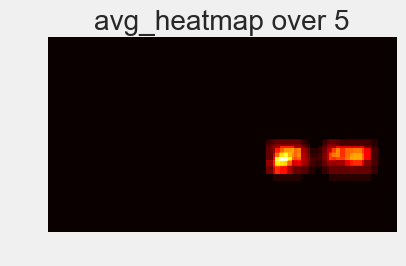

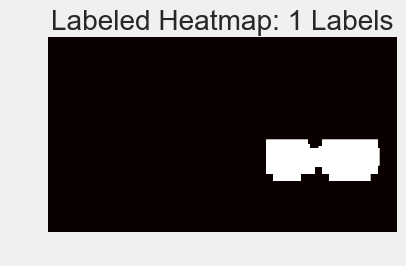

 10%|████▍                                      | 4/39 [00:05<00:46,  1.33s/it]

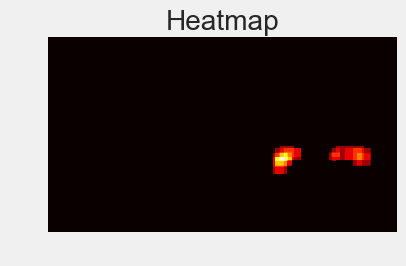

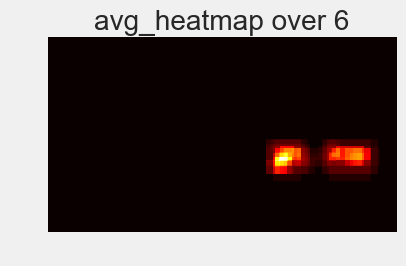

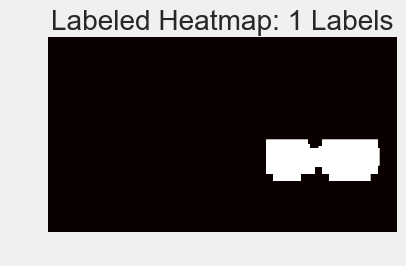

 13%|█████▌                                     | 5/39 [00:06<00:45,  1.33s/it]

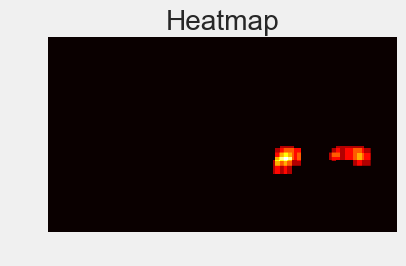

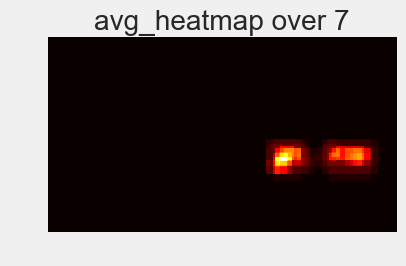

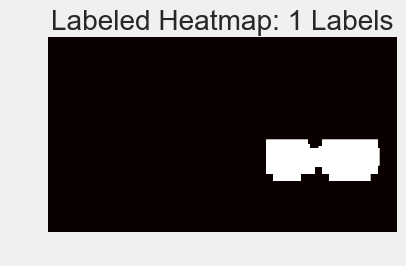

 15%|██████▌                                    | 6/39 [00:08<00:43,  1.33s/it]

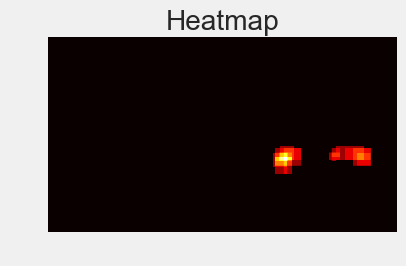

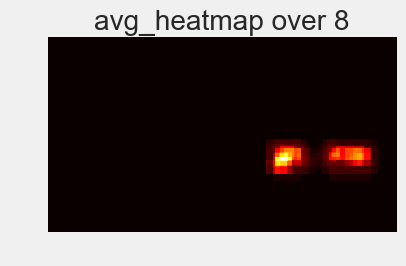

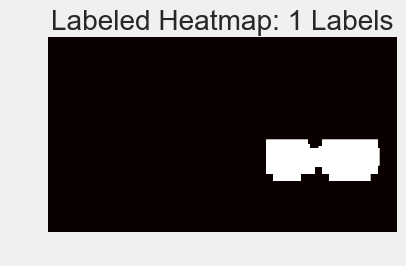

 18%|███████▋                                   | 7/39 [00:09<00:43,  1.37s/it]

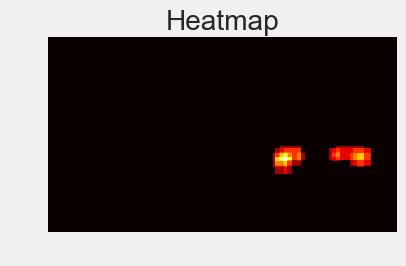

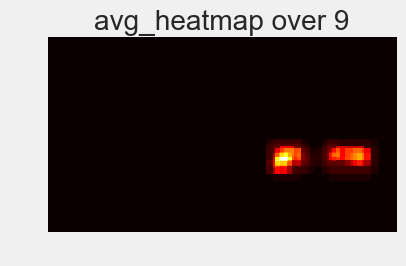

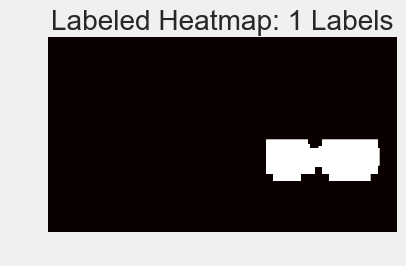

 21%|████████▊                                  | 8/39 [00:10<00:41,  1.35s/it]

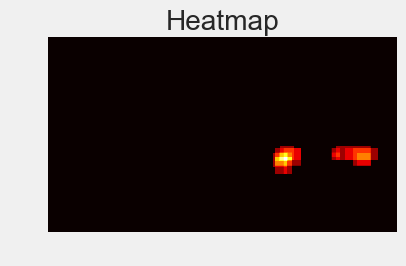

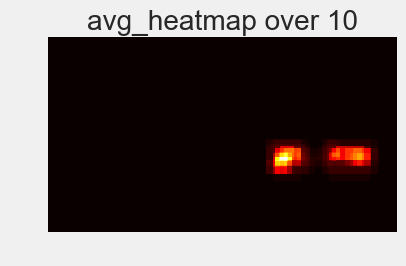

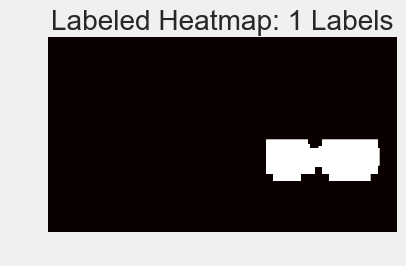

 23%|█████████▉                                 | 9/39 [00:12<00:40,  1.34s/it]

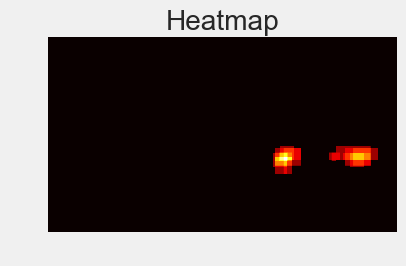

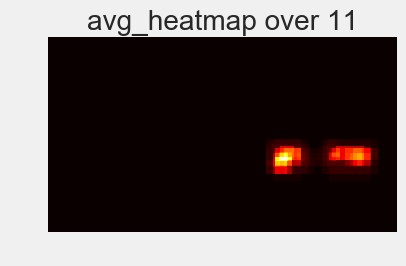

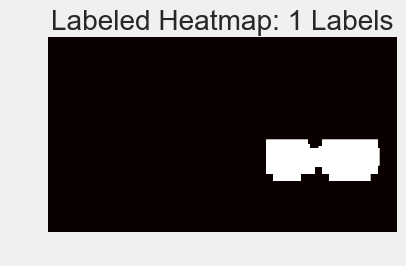

 26%|██████████▊                               | 10/39 [00:13<00:38,  1.33s/it]

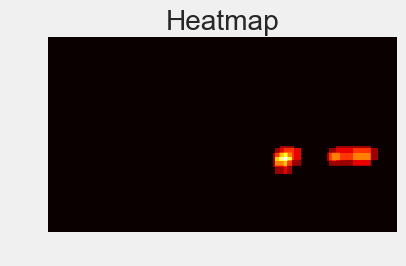

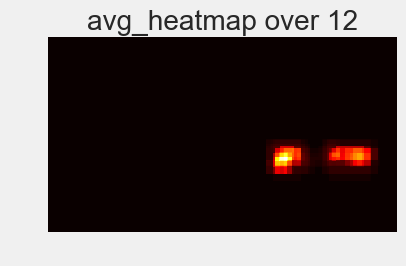

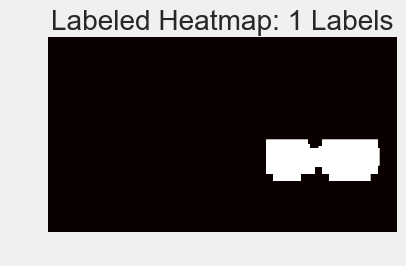

 28%|███████████▊                              | 11/39 [00:14<00:38,  1.36s/it]

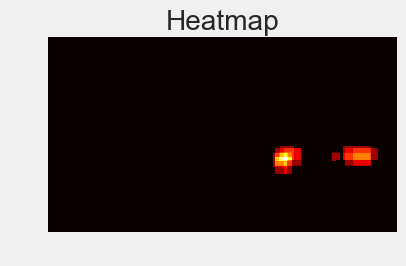

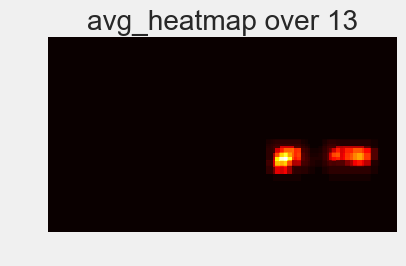

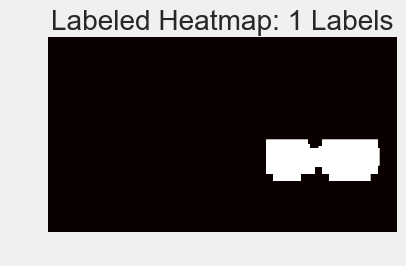

 31%|████████████▉                             | 12/39 [00:16<00:36,  1.36s/it]

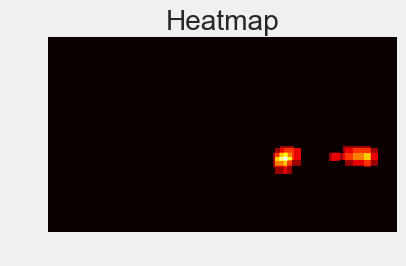

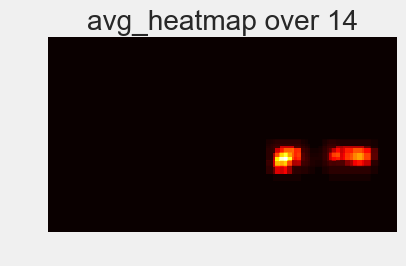

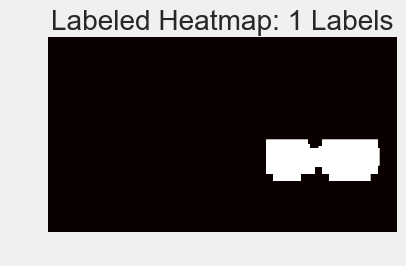

 33%|██████████████                            | 13/39 [00:17<00:35,  1.37s/it]

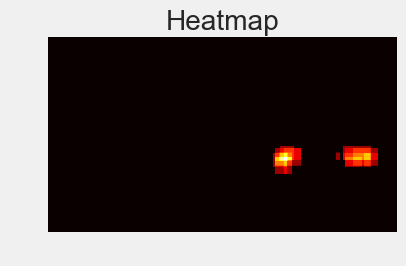

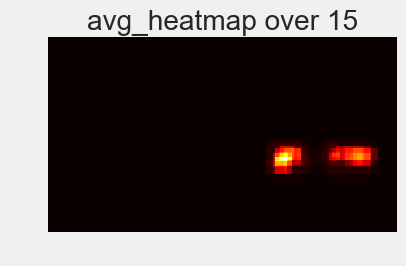

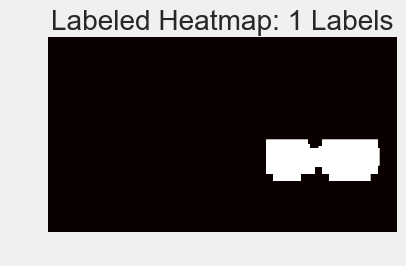

 36%|███████████████                           | 14/39 [00:18<00:34,  1.37s/it]

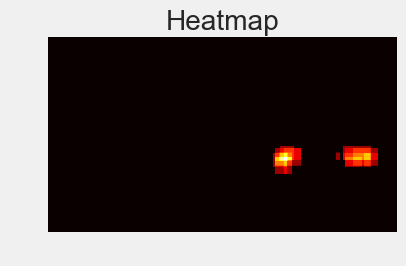

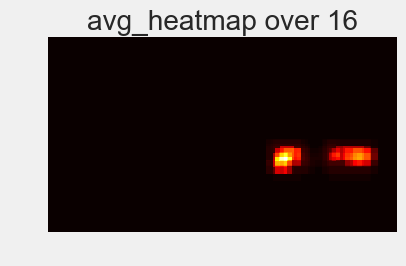

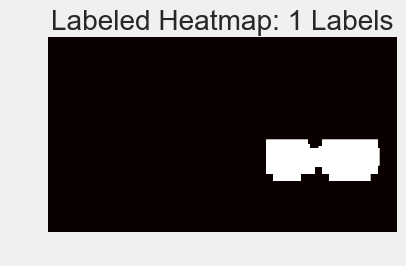

 38%|████████████████▏                         | 15/39 [00:20<00:34,  1.42s/it]

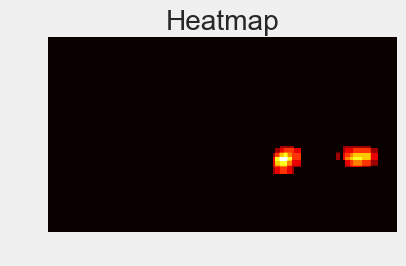

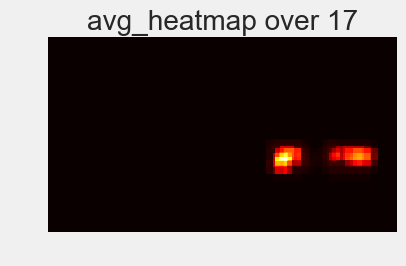

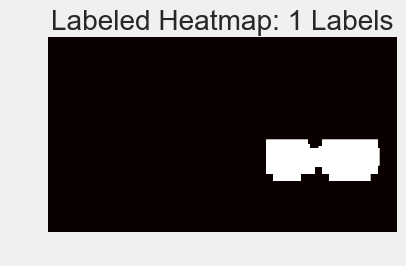

 41%|█████████████████▏                        | 16/39 [00:21<00:31,  1.39s/it]

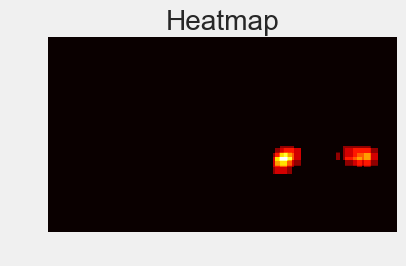

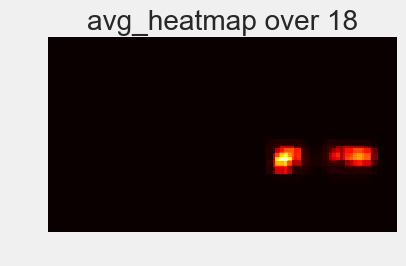

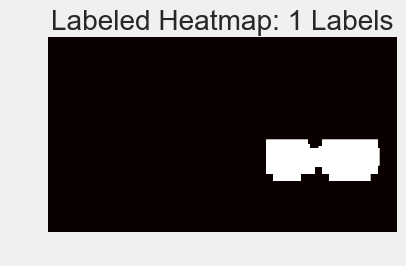

 44%|██████████████████▎                       | 17/39 [00:23<00:30,  1.37s/it]

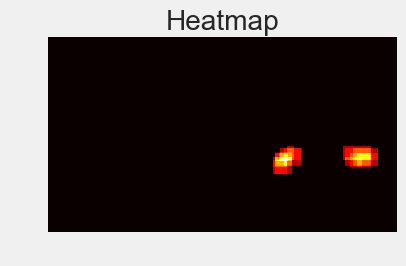

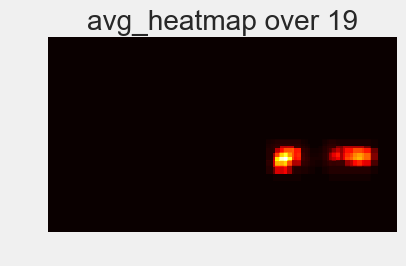

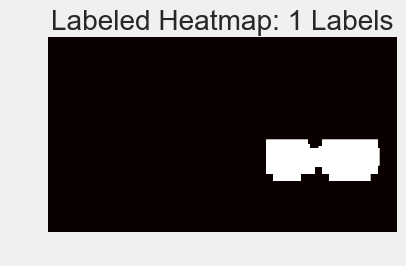

 46%|███████████████████▍                      | 18/39 [00:24<00:28,  1.36s/it]

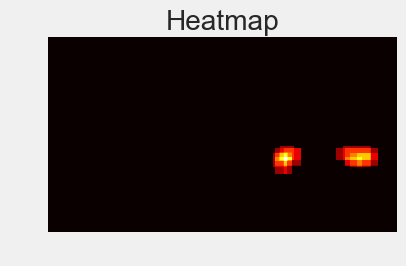

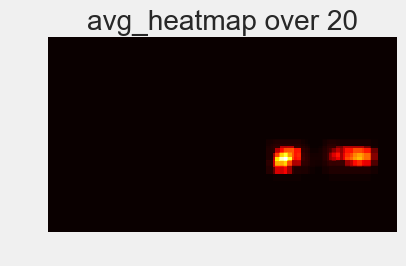

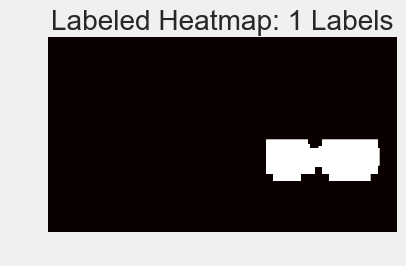

 49%|████████████████████▍                     | 19/39 [00:25<00:26,  1.34s/it]

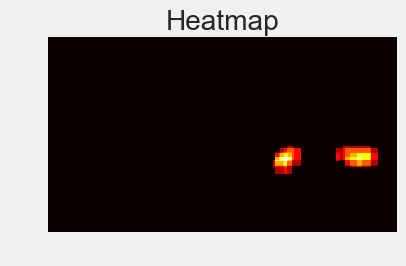

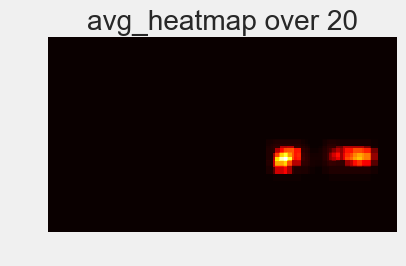

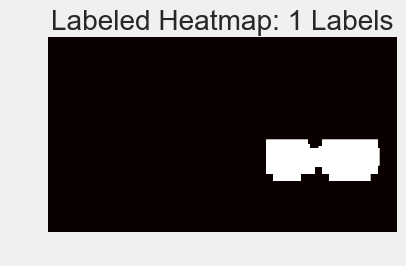

 51%|█████████████████████▌                    | 20/39 [00:27<00:26,  1.39s/it]

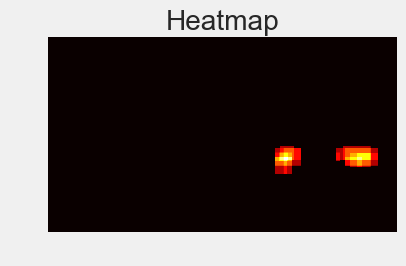

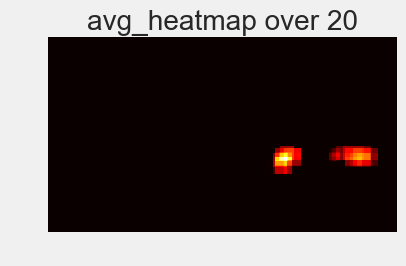

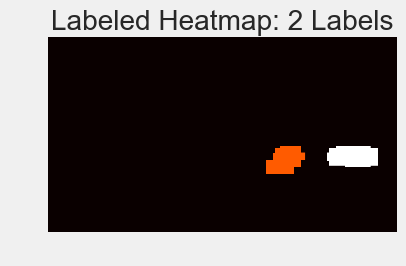

 54%|██████████████████████▌                   | 21/39 [00:28<00:24,  1.38s/it]

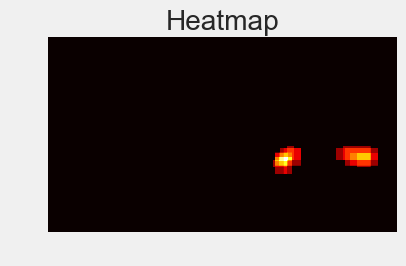

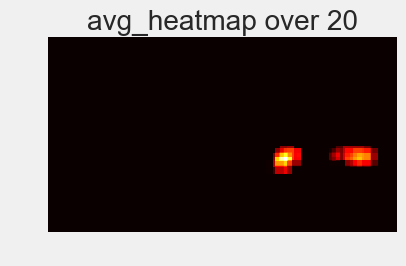

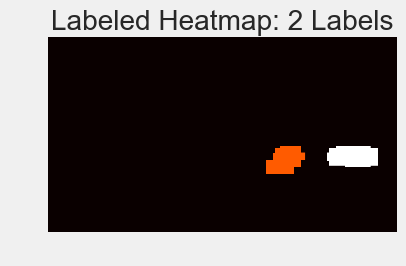

 56%|███████████████████████▋                  | 22/39 [00:29<00:23,  1.36s/it]

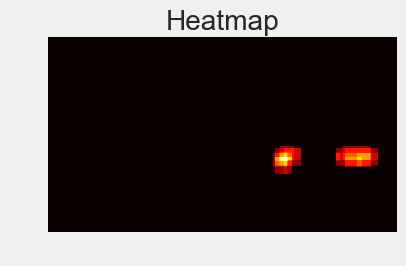

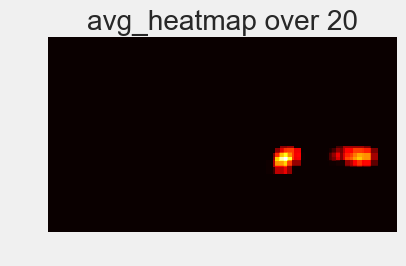

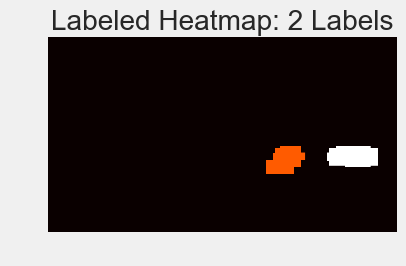

 59%|████████████████████████▊                 | 23/39 [00:31<00:21,  1.36s/it]

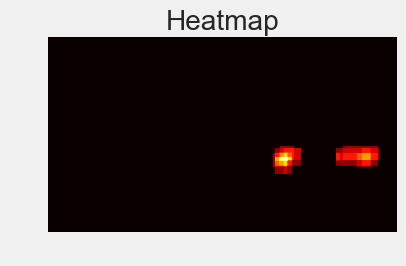

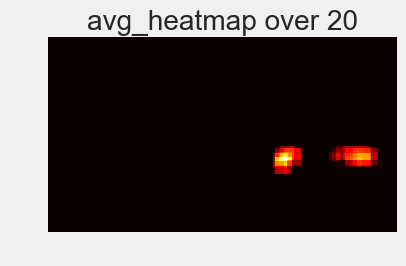

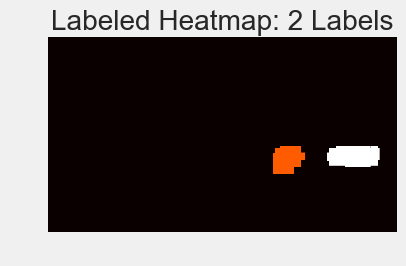

 62%|█████████████████████████▊                | 24/39 [00:32<00:20,  1.38s/it]

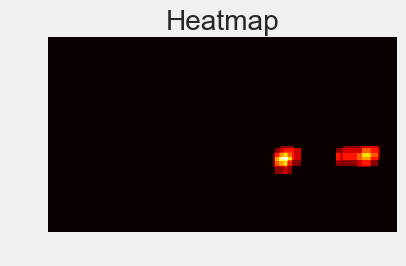

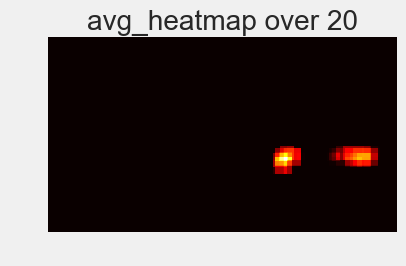

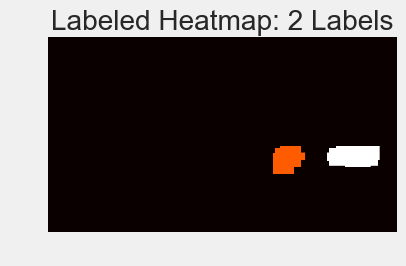

 64%|██████████████████████████▉               | 25/39 [00:34<00:19,  1.37s/it]

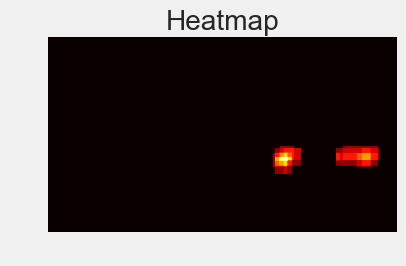

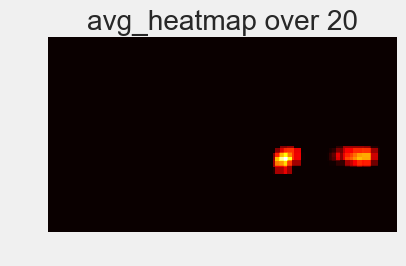

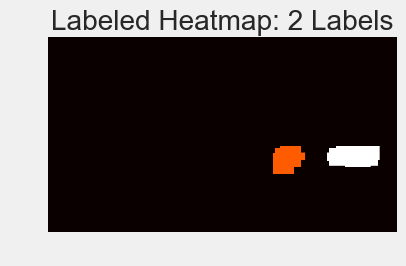

 67%|████████████████████████████              | 26/39 [00:35<00:18,  1.39s/it]

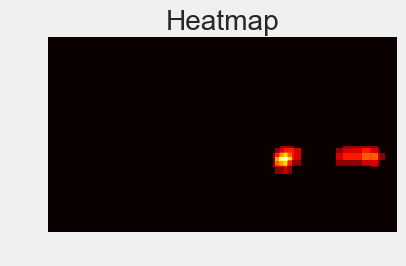

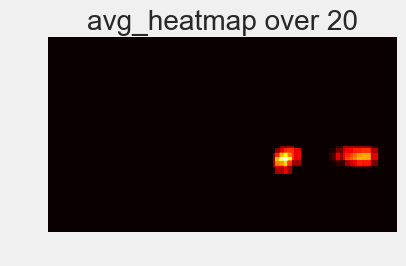

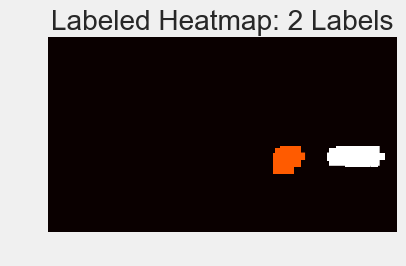

 69%|█████████████████████████████             | 27/39 [00:36<00:16,  1.39s/it]

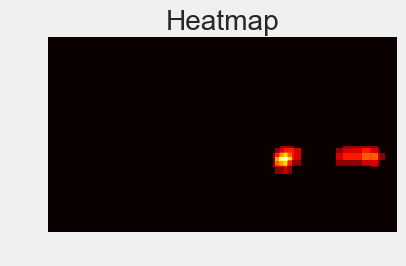

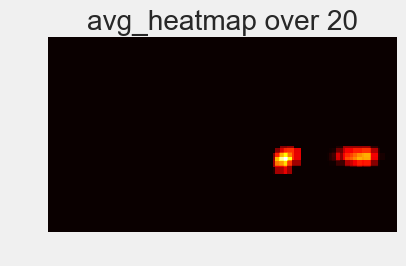

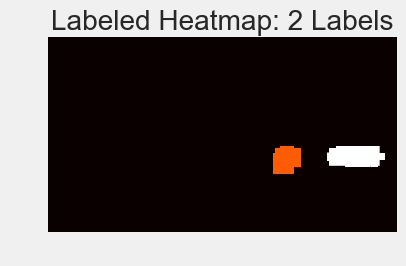

 72%|██████████████████████████████▏           | 28/39 [00:38<00:15,  1.41s/it]

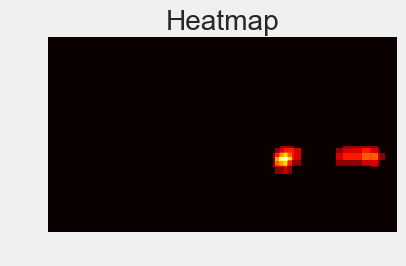

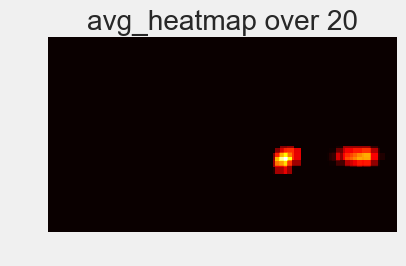

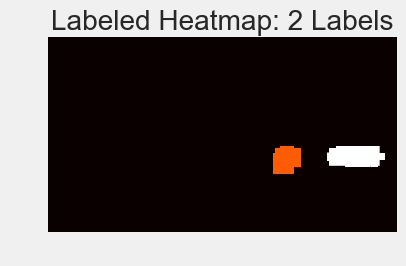

 74%|███████████████████████████████▏          | 29/39 [00:39<00:13,  1.39s/it]

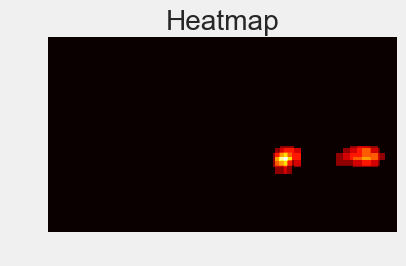

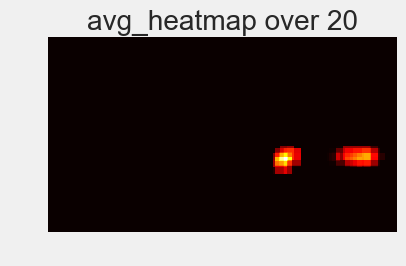

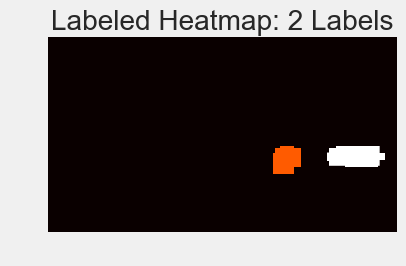

 77%|████████████████████████████████▎         | 30/39 [00:41<00:12,  1.39s/it]

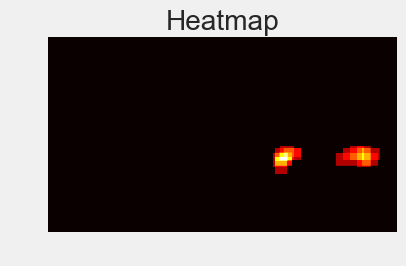

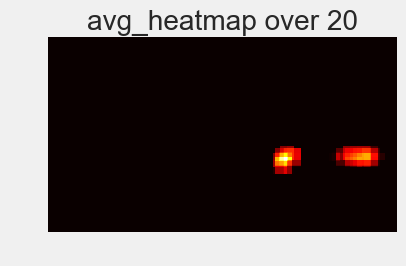

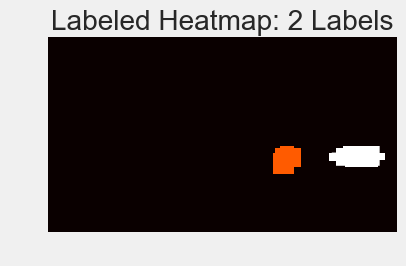

 79%|█████████████████████████████████▍        | 31/39 [00:42<00:11,  1.39s/it]

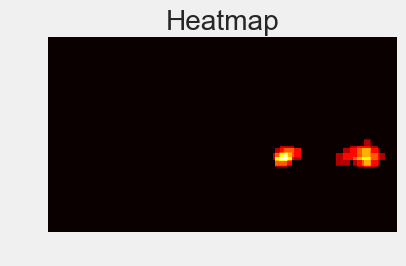

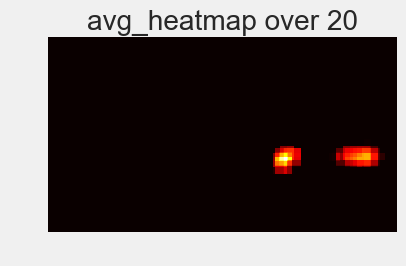

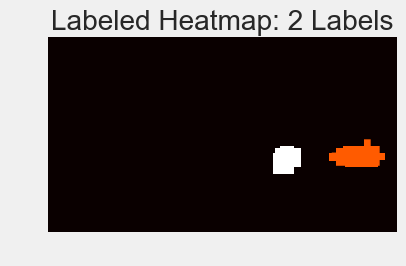

 82%|██████████████████████████████████▍       | 32/39 [00:43<00:09,  1.38s/it]

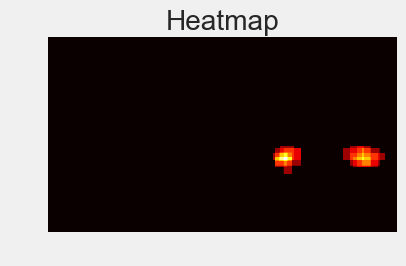

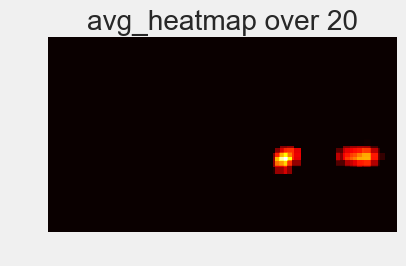

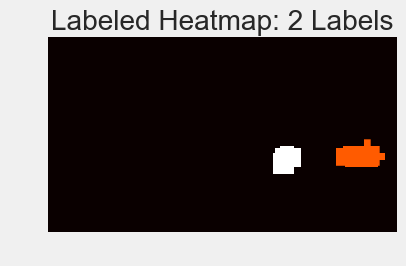

 85%|███████████████████████████████████▌      | 33/39 [00:45<00:08,  1.40s/it]

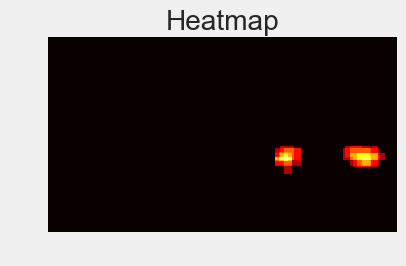

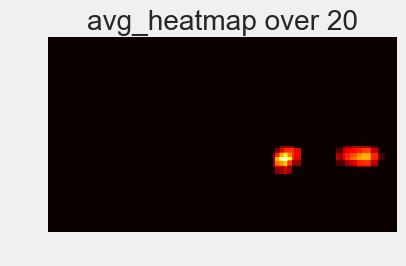

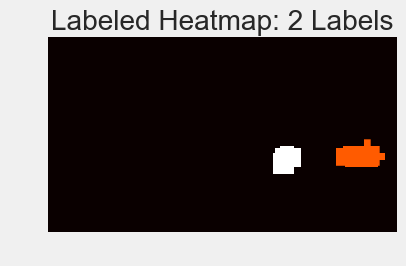

 87%|████████████████████████████████████▌     | 34/39 [00:46<00:06,  1.38s/it]

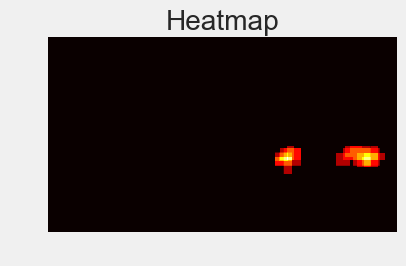

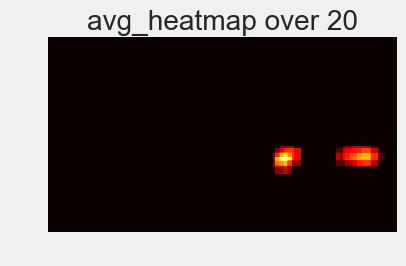

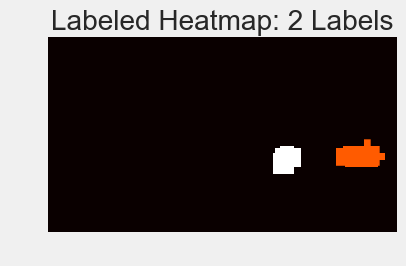

 90%|█████████████████████████████████████▋    | 35/39 [00:47<00:05,  1.36s/it]

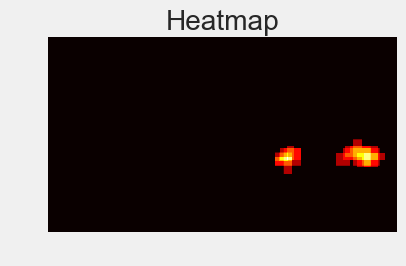

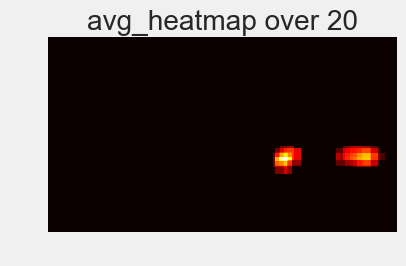

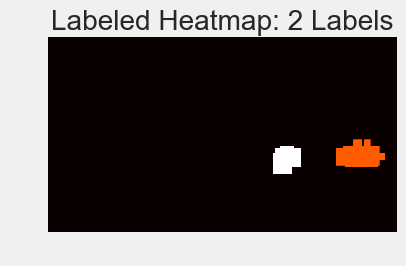

 92%|██████████████████████████████████████▊   | 36/39 [00:49<00:04,  1.36s/it]

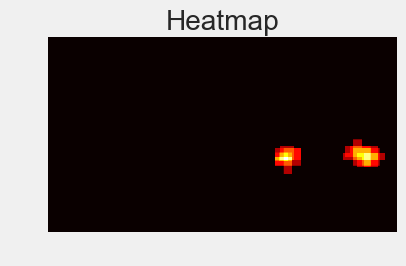

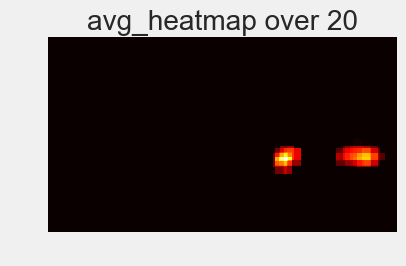

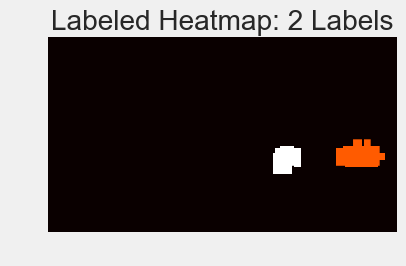

 95%|███████████████████████████████████████▊  | 37/39 [00:50<00:02,  1.39s/it]

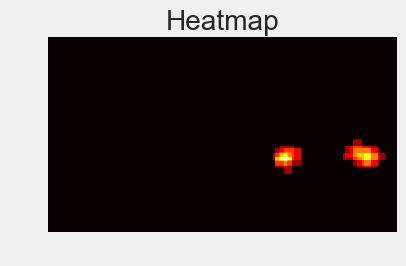

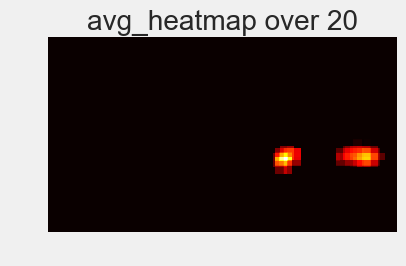

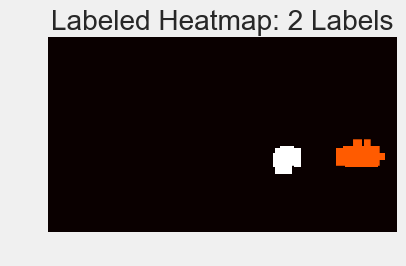

 97%|████████████████████████████████████████▉ | 38/39 [00:52<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project-video-output-short.mp4 

Wall time: 53.2 s


In [183]:
# clip = mp.VideoFileClip('../snowsports/test.MP4').subclip(220,224)
clip1 = []

# create tracking object
tracker = VehicleTracker()
tracker.debug_flag = False

project_output = 'project-video-output-short.mp4'
clip1 = VideoFileClip('test_video.mp4', audio=False)
proj_clip = clip1.fl_image(tracker.process_image)
%time proj_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

### Long Video Clip

In [10]:
clip1 = []
# create tracking object
tracker = VehicleTracker()

project_output = 'project_video.mp4'
clip1 = VideoFileClip('output-project-video.mp4')
# clip1 = clip1.subclip(-20, -10)
proj_clip = clip1.fl_image(tracker.process_image)
%time proj_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

VehicleTracker created...
[MoviePy] >>>> Building video output-images/project-output-with-lanes.mp4
[MoviePy] Writing video output-images/project-output-with-lanes.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:53<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output-images/project-output-with-lanes.mp4 

Wall time: 15min 54s
